In [36]:
from lcapy import L,C,R
import lcapy
import sympy as sp
import numpy as np
from scipy.constants import e,pi,h
from sympy.core.mul import Mul,Pow,Add
from copy import deepcopy
import matplotlib.pyplot as plt
import math

In [92]:
def admittance(circuit):
    if type(circuit) == lcapy.oneport.Par:
        return Add(admittance(circuit.args[0]),admittance(circuit.args[1]))
    elif type(circuit) == lcapy.oneport.Ser:
        return 1/Add(1/admittance(circuit.args[0]),1/admittance(circuit.args[1]))
    elif type(circuit) == lcapy.oneport.L:
        return -sp.I*Mul(1/sp.Symbol('w'),1/sp.Symbol(circuit.args[0],real=True))
    elif type(circuit) == lcapy.oneport.C:
        return sp.I*Mul(sp.Symbol('w'),sp.Symbol(circuit.args[0],real=True))
    elif type(circuit) == lcapy.oneport.R:
        return 1/sp.Symbol(circuit.args[0],real=True)

class Bbox(object):
    def __init__(self, circuit, L_J = "L_J"):
        self.circuit = circuit
        self.L_J = L_J
        
        Y = admittance(circuit)
        self.all_circuit_elements = [str(x) for x in list(Y.free_symbols)]
        self.all_circuit_elements.remove('w')

        Y_numer = sp.numer(sp.together(Y))
        Y_poly = sp.collect(sp.expand(Y_numer),sp.Symbol('w'))
        self.Y_poly = Y_poly
        Y_poly_order = sp.polys.polytools.degree(Y_poly,gen = sp.Symbol('w'))
        Y_poly_coeffs = [Y_poly.coeff(sp.Symbol('w'),n) for n in range(Y_poly_order+1)[::-1]]
        self.Y_poly_num = sp.utilities.lambdify([elt for elt in self.all_circuit_elements],Y_poly_coeffs,"numpy")
        self.N_modes = int(math.ceil((Y_poly_order)/2))
        self.dY = sp.diff(Y,sp.Symbol('w'))
        self.dY_num = sp.utilities.lambdify([elt for elt in self.all_circuit_elements+["w"]],self.dY,"numpy")
    
    def draw(self):
        self.circuit.draw()
        
    def analytical_solution(self):
        # Prints very ugly expressions, need to massage the sympy
        facts = [sp.Q.positive(sp.Symbol(x)) for x in self.all_circuit_elements]
        with sp.assuming(*facts):
        
            # Try and calculate analytical eigenfrequencies
            w_analytical = sp.solve(self.Y_poly,sp.Symbol('w'))

            # Check the number of solutions
            if len(w_analytical)==0:
                print "No analytical solutions"
                return None

            # Compute anharmonicities
            ws = []
            ks = []
            As = []
            for w in w_analytical:
                w_num = complex(w.evalf(subs={i:1. for i in w.free_symbols}))
                if np.real(w_num)>0:
                    ws.append(sp.functions.im(w))
                    ks.append(-sp.functions.re(w))
                    As.append(2.*e**2/h*Mul(1/sp.Symbol(self.L_J),\
                            Mul(Pow(1/sp.functions.im(self.dY.subs({sp.Symbol('w'):sp.functions.im(w)})),2),\
                            Pow(1/sp.functions.im(w),2))))
            return ws,ks,As
    
    def fkA(self,circuit_parameters):
        args = [circuit_parameters[key] for key in self.all_circuit_elements]
        ws_cpx = np.roots(self.Y_poly_num(*args))
        positive_sols = np.argwhere(np.real(ws_cpx)>=0.)
        ws_cpx=ws_cpx[positive_sols][:,0]
        while True:
            if len(ws_cpx)<self.N_modes:
                ws_cpx=np.concatenate((ws_cpx,[0.]))
            else:
                break
        
        ws = np.real(ws_cpx)
        increasing_frequencies = np.argsort(ws)
        ws = ws[increasing_frequencies]
        ks = np.imag(ws_cpx)[increasing_frequencies]
        
        
        args.append(ws)
        ImdY = np.imag(self.dY_num(*args))
        As = 2.*e**2/h/circuit_parameters[self.L_J]/ws**2/ImdY**2
        return np.concatenate(([ws/2./pi],[ks/2./pi],[As]))
    
    def normalmodes(self,circuit_parameters):
        N_lists = 0
        for key in circuit_parameters:
            if type(circuit_parameters[key]) == np.ndarray or type(circuit_parameters[key])== list:
                N_lists +=1
                key_list = key
        
        if N_lists == 0:
            return self.fkA(circuit_parameters)
        elif N_lists == 1:
            to_iterate = deepcopy(circuit_parameters[key_list])
            circuit_parameters[key_list] = to_iterate[0]
            ret = np.array([self.fkA(circuit_parameters)])
            for key_value in to_iterate[1:]:
                circuit_parameters[key_list] = key_value
                ret = np.concatenate((ret,[self.fkA(circuit_parameters)]),axis = 0)
            return np.transpose(ret,(2,1,0))
        else:
            "Can only iterate on one variable"


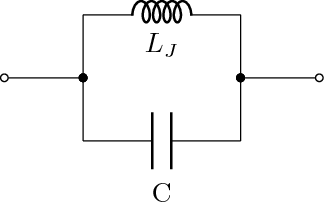

In [93]:
b = Bbox(L('L_J') | C('C'))
b.draw()

In [94]:
b.normalmodes({
    'L_J':10e-9,
    'C':100e-15
})

array([[5.03292121e+09],
       [0.00000000e+00],
       [1.93702293e+08]])

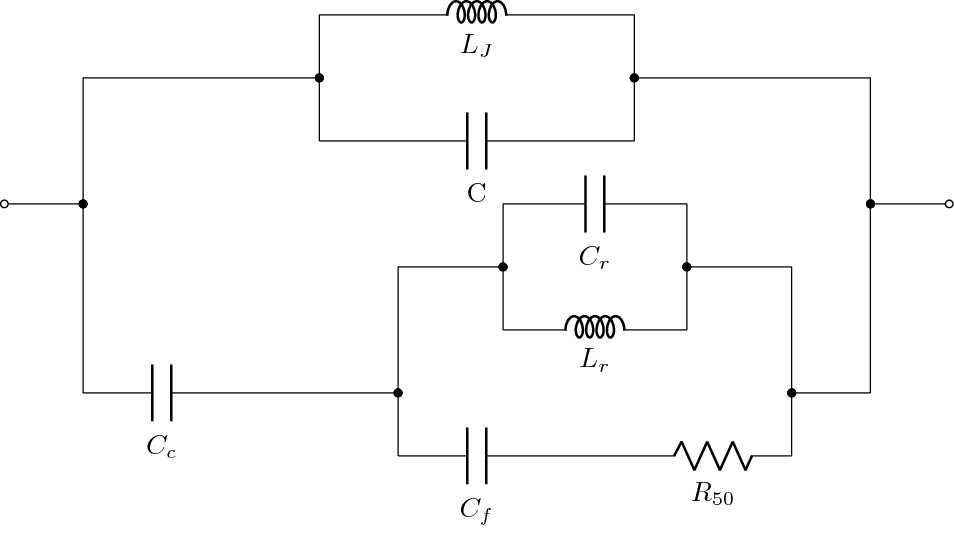

In [95]:
b = Bbox(L('L_J') | C('C') | (C('Cc')+(C('Cr')|L('Lr')|(C('Cf')+R('R_50')))))
# b = Bbox(L('L_J') | C('C') | R('R_J')|(C('Cc')+(C('Cr')|L('Lr')|R('R_r')|(C('Cf')+R('R_50')))))
b.draw()

In [101]:
flux = np.linspace(0.,0.2,103)
L_J_list = 7e-9/np.cos(2.*pi*flux)
to_plot =  np.array(b.normalmodes({
    'L_J':L_J_list,
    'C':100e-15,
    'Cc':10e-15,
    'Cf':1e-15,
    'R_50':50.,
    'Lr':10e-9,
    'Cr':100e-15,
    'R_J':1e6,
    'R_r':1e5
}))


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:79: RuntimeWarning: divide by zero encountered in divide


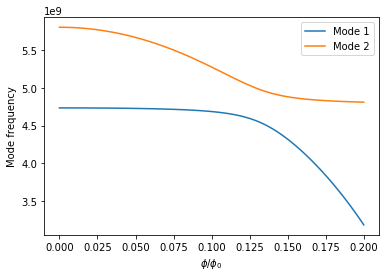

In [102]:
plt.plot(flux,to_plot[1,0,:],label = 'Mode 1')
plt.plot(flux,to_plot[2,0,:],label = 'Mode 2')
plt.ylabel("Mode frequency")
plt.xlabel("$\phi/\phi_0$")
plt.legend()
plt.show()

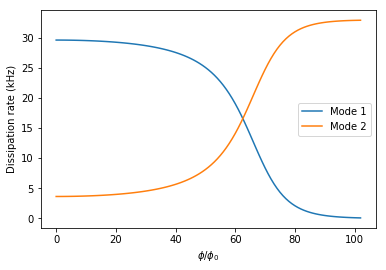

In [103]:
plt.plot(to_plot[1,1,:]/1e3,label = 'Mode 1')
plt.plot(to_plot[2,1,:]/1e3,label = 'Mode 2')
plt.ylabel("Dissipation rate (kHz)")
plt.xlabel("$\phi/\phi_0$")
plt.legend()
plt.show()

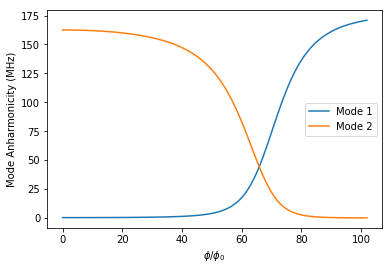

In [104]:
plt.plot(to_plot[1,2,:]/1e6,label = 'Mode 1')
plt.plot(to_plot[2,2,:]/1e6,label = 'Mode 2')
plt.ylabel("Mode Anharmonicity (MHz)")
plt.xlabel("$\phi/\phi_0$")
plt.legend()
plt.show()